# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 

from sklearn.metrics import confusion_matrix

from scipy import signal

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason
from keras.optimizers import Adam
from keras import backend as K
model = None

Using TensorFlow backend.


In [2]:
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


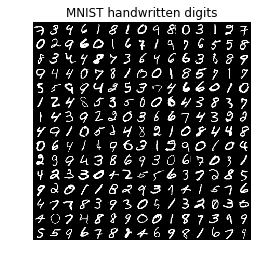

In [3]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )
## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)

In [3]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

batch_size = 100
max_epochs = 10

## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [6]:
tf.reset_default_graph()

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')

    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
Flatten 	 (?, 3136)
denseOut	 (?, 10)
Model consits of  31786 trainable parameters.


In [7]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
## Launch TensorBoard, and visualize the TF graph

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [9]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [10]:
#Training Loop
valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            
            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))

    except KeyboardInterrupt:
        pass

Begin training loop
Epoch 1 : Train Loss  0.147, Train acc  0.950,  Valid loss  0.136,  Valid acc  0.962
Epoch 2 : Train Loss  0.115, Train acc  0.950,  Valid loss  0.092,  Valid acc  0.974
Epoch 3 : Train Loss  0.049, Train acc  0.990,  Valid loss  0.074,  Valid acc  0.977
Epoch 4 : Train Loss  0.022, Train acc  1.000,  Valid loss  0.066,  Valid acc  0.980
Epoch 5 : Train Loss  0.027, Train acc  0.990,  Valid loss  0.058,  Valid acc  0.983
Epoch 6 : Train Loss  0.013, Train acc  1.000,  Valid loss  0.055,  Valid acc  0.984
Epoch 7 : Train Loss  0.020, Train acc  1.000,  Valid loss  0.056,  Valid acc  0.983
Epoch 8 : Train Loss  0.136, Train acc  0.970,  Valid loss  0.053,  Valid acc  0.985
Epoch 9 : Train Loss  0.015, Train acc  1.000,  Valid loss  0.053,  Valid acc  0.985
Epoch 10 : Train Loss  0.043, Train acc  0.980,  Valid loss  0.052,  Valid acc  0.987
Test Loss  0.048, Test acc  0.986


(<matplotlib.text.Text at 0x231370b0d30>,
 (0.75, 1.03))

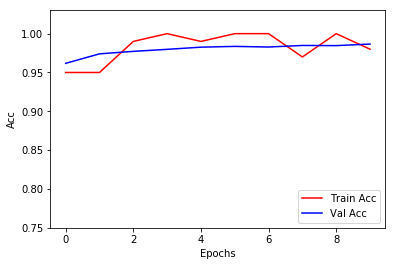

In [12]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments

## <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

<span style="color:blue"> Answer: </span>





<span style="color:blue">We just place the kernel matrix on top of the pixels and multiply, just as shown in the first notebook.</span>

\begin{align}
    y_{0,0} &= 1 \cdot 2 +2 \cdot 3 = 8 \\
    y_{1,0} &= 2 \cdot 1 + 2 \cdot 1 + 2 \cdot 2 + 2 \cdot 3 = 14 \\
    y_{0,1} &= 2 \cdot 2 + 2 \cdot 2 + 3 \cdot 3 + 1 \cdot 1 + 2 \cdot 2 = 20 \\
    y_{1,1} &= 2 \cdot 2 + 2 \cdot 1 + 2 \cdot 2 + 3 \cdot 2 + 3 \cdot 3 = 25
\end{align}

<span style="color:blue">We can verify the result with scipy</span>

In [23]:
x = np.array([[0, 0, 0, 1],[0, 0,1,2],[0,0,2,3],[0,1,2,3]])
k=np.array([[0,0,2],[0,1,2],[0,2,3]])
k = np.rot90(k, 2)
y = signal.convolve2d(x, k, 'valid')

print(y)

[[ 8 20]
 [14 25]]


<span style="color:blue">Performing 2x2 max poolin on this will just give us 25.


## <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>

``` 
Paste your code here
```


``` 
Paste the trace of the tensors shape as it is propagated through the network here
```


<span style="color:blue">I need to import this again, otherwise the training will fail.</span>

In [33]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


<span style="color:blue">I define the network</span>

In [35]:
tf.reset_default_graph()

filters_1 = 32
kernel_size_1 = (3,3)
pool_size_1 = (2,2)

filters_2 = 64
kernel_size_2 = (3,3)
pool_size_2 = (2, 2)

filters_3 = 14
kernel_size_3 = (3,3)
pool_size_3 = (7, 7)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())

with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
with tf.variable_scope('convLayer3'):
    conv3 = Conv2D(filters_3, kernel_size_3, strides=(1,1), padding=padding, activation='relu')
    x = conv3(x)
    print('conv3 \t\t', x.get_shape())

    pool3 = MaxPooling2D(pool_size=pool_size_3, strides=None, padding=padding)
    x = pool3(x)
    print('pool3 \t\t', x.get_shape())

    x = flatten(x)
    print('Flatten \t', x.get_shape())     

with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')

    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 32)
pool1 		 (?, 14, 14, 32)
conv2 		 (?, 14, 14, 64)
pool2 		 (?, 7, 7, 64)
conv3 		 (?, 7, 7, 14)
pool3 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  27044 trainable parameters.


<span style="color:blue">To get 1x1xF, I just maxpool 7x7 (what we have before)</span>

In [36]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add saver op to restore the model for prediction  
saver = tf.train.Saver()

In [37]:
#Training Loop
batch_size = 100
max_epochs = 10

valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))
        
        saver.save(sess, './mnist_cnn')
        
    except KeyboardInterrupt:
        pass

Begin training loop
Epoch 0 : Train Loss  2.314, Train acc  0.040,  Valid loss  2.298,  Valid acc  0.119
Epoch 1 : Train Loss  0.125, Train acc  0.940,  Valid loss  0.189,  Valid acc  0.948
Epoch 2 : Train Loss  0.149, Train acc  0.970,  Valid loss  0.146,  Valid acc  0.955
Epoch 3 : Train Loss  0.034, Train acc  0.990,  Valid loss  0.102,  Valid acc  0.972
Epoch 4 : Train Loss  0.037, Train acc  0.990,  Valid loss  0.114,  Valid acc  0.967
Epoch 5 : Train Loss  0.073, Train acc  0.980,  Valid loss  0.078,  Valid acc  0.976
Epoch 6 : Train Loss  0.036, Train acc  0.990,  Valid loss  0.066,  Valid acc  0.980
Epoch 7 : Train Loss  0.008, Train acc  1.000,  Valid loss  0.080,  Valid acc  0.977
Epoch 8 : Train Loss  0.020, Train acc  1.000,  Valid loss  0.057,  Valid acc  0.983
Epoch 9 : Train Loss  0.018, Train acc  1.000,  Valid loss  0.055,  Valid acc  0.984
Epoch 10 : Train Loss  0.021, Train acc  0.990,  Valid loss  0.054,  Valid acc  0.985
Test Loss  0.048, Test acc  0.984


(<matplotlib.text.Text at 0x1cd688f9be0>,
 (0.75, 1.03))

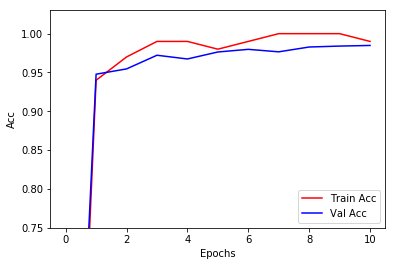

In [39]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

<span style="color:blue">We can then make predictions on the test set</span>

In [40]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_cnn')
    feed_dict_valid = {x_pl: mnist_data.test.images, y_pl: mnist_data.test.labels}

    # deciding which parts to fetch
    fetches_valid = [accuracy]          

    # running the validation
    test_acc = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
    
    y_pred = pred(mnist_data.test.images, sess)    # Get predictions
    
    y_pred_1 = np.zeros_like(y_pred) # Make new matrix to contain one-hot encoded values of y_pred
    y_pred_1[np.arange(len(y_pred)), y_pred.argmax(1)] = 1 # Sets max to 1 and everything else to 

INFO:tensorflow:Restoring parameters from ./mnist_cnn


In [41]:
print('The test accuracy using elu is {}'.format(test_acc))

The test accuracy using elu is [0.98420012]


## <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>


In [34]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


<span style="color:blue">I just remove one layer and reduce the number of filters.</span>

In [35]:
tf.reset_default_graph()

filters_1 = 10
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 14
kernel_size_2 = (3,3)
pool_size_2 = (filters_2, filters_2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
    x = flatten(x)
    print('Flatten \t', x.get_shape()) 
    
with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 10)
pool1 		 (?, 14, 14, 10)
conv2 		 (?, 14, 14, 14)
pool2 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  1684 trainable parameters.


<span style="color:blue">So now, we only have 1684 parameters.</span>

In [36]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
# Add saver op to restore the model for prediction  
saver = tf.train.Saver()

In [37]:
#Training Loop
batch_size = 100
max_epochs = 10

valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))
        
        saver.save(sess, './mnist_cnn')
        
    except KeyboardInterrupt:
        pass

Begin training loop
Epoch 0 : Train Loss  2.379, Train acc  0.110,  Valid loss  2.354,  Valid acc  0.087
Epoch 1 : Train Loss  0.626, Train acc  0.830,  Valid loss  0.582,  Valid acc  0.835
Epoch 2 : Train Loss  0.433, Train acc  0.870,  Valid loss  0.364,  Valid acc  0.893
Epoch 3 : Train Loss  0.289, Train acc  0.890,  Valid loss  0.302,  Valid acc  0.911
Epoch 4 : Train Loss  0.198, Train acc  0.950,  Valid loss  0.249,  Valid acc  0.926
Epoch 5 : Train Loss  0.231, Train acc  0.900,  Valid loss  0.233,  Valid acc  0.933
Epoch 6 : Train Loss  0.096, Train acc  0.980,  Valid loss  0.213,  Valid acc  0.936
Epoch 7 : Train Loss  0.286, Train acc  0.920,  Valid loss  0.199,  Valid acc  0.937
Epoch 8 : Train Loss  0.118, Train acc  0.980,  Valid loss  0.192,  Valid acc  0.941
Epoch 9 : Train Loss  0.168, Train acc  0.950,  Valid loss  0.187,  Valid acc  0.942
Epoch 10 : Train Loss  0.200, Train acc  0.940,  Valid loss  0.176,  Valid acc  0.946
Test Loss  0.173, Test acc  0.947


(<matplotlib.text.Text at 0x2313c1e5908>,
 (0.75, 1.03))

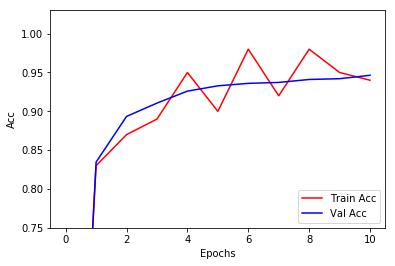

In [38]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

<span style="color:blue">We can then make predictions on the test set</span>

In [41]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_cnn')
    feed_dict_valid = {x_pl: mnist_data.test.images, y_pl: mnist_data.test.labels}

    # deciding which parts to fetch
    fetches_valid = [accuracy]          

    # running the validation
    test_acc = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
    
    y_pred = pred(mnist_data.test.images, sess)    # Get predictions
    
    y_pred_1 = np.zeros_like(y_pred) # Make new matrix to contain one-hot encoded values of y_pred
    y_pred_1[np.arange(len(y_pred)), y_pred.argmax(1)] = 1 # Sets max to 1 and everything else to 0.

INFO:tensorflow:Restoring parameters from ./mnist_cnn


In [43]:
print('The test accuracy using elu is {}'.format(test_acc))

The test accuracy using elu is [0.94680017]


## <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___



<span style="color:blue">If you run this notebook, you may be required to restart the kernel for this section, the first cells then need to be executed again for the variables and modules.</span>

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=True, # Flatten the images to vectors
                                      )

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [5]:
num_features

784

<span style="color:blue">As a vector, we have 784 features, this means that with just 2 neurons in the hidden layer, we will have 1568 weights.</span>

In [6]:
model = None

session = K.get_session()
if model is not None:
    model.reset_states() # Reset graph

n_hidden1 = 2

model = Sequential()

model.add(Dense(n_hidden1, activation='elu', input_dim=num_features))
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
epochs = 10
batch_size = 100

#history = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=100, epochs=10)

for e in range(epochs):
    train_loss = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=batch_size, nb_epoch=1, verbose = 0)
    val_score, val_acc = model.evaluate(mnist_data.validation.images, mnist_data.validation.labels, batch_size=batch_size, verbose = 0)
    
    print("Validation accuracy: {}".format(val_acc))

C:\Developer\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.469999987483
0.532599983215
0.559799978137
0.566799976826
0.580399978757
0.593399971724
0.59839998126
0.599999974966
0.606199983358
0.611599975228


<span style="color:blue">We then obtain the test accuracy</span>

In [14]:
score, acc = model.evaluate(mnist_data.test.images, mnist_data.test.labels, verbose=0)

print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.14701682673
Test accuracy: 0.6006


<span style="color:blue">So it is significantly worse than the convolutional neural network.</span>

## Book Exercise